<a href="https://colab.research.google.com/github/zhaoheng001/acai/blob/master/lines32_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from __future__ import absolute_import
from __future__ import division


import functools
import glob
import math




import tensorflow as tf
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
def draw_line(angle, height, width, w=2.):
    m = np.zeros((height, width, 1))
    x0 = height*0.5
    y0 = width*0.5
    x1 = x0 + (x0 - 1) * math.cos(-angle)
    y1 = y0 + (y0 - 1) * math.sin(-angle)
    flip = False
    if abs(y0 - y1) < abs(x0 - x1):
        x0, x1, y0, y1 = y0, y1, x0, x1
        flip = True
    if y1 < y0:
        x0, x1, y0, y1 = x1, x0, y1, y0
    x0, x1 = x0 - w / 2, x1 - w / 2
    dx = x1 - x0
    dy = y1 - y0
    ds = dx / dy if dy != 0 else 0
    yi = int(math.ceil(y0)), int(y1)
    points = []
    for y in range(int(y0), int(math.ceil(y1))):
        if y < yi[0]:
            weight = yi[0] - y0
        elif y > yi[1]:
            weight = y1 - yi[1]
        else:
            weight = 1
        xs = x0 + (y - y0 - .5) * ds
        xe = xs + w
        xi = int(math.ceil(xs)), int(xe)
        if xi[0] != xi[1]:
            points.append((y, slice(xi[0], xi[1]), weight))
        if xi[0] != xs:
            points.append((y, int(xs), weight * (xi[0] - xs)))
        if xi[1] != xe:
            points.append((y, xi[1], weight * (xe - xi[1])))
    if flip:
        points = [(x, y, z) for y, x, z in points]
    for y, x, z in points:
        m[y, x] += 2 * z
    m -= 1
    m = m.clip(-1, 1)
    return m

(32, 32, 1)


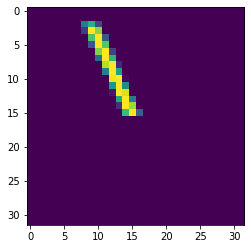

In [4]:
x = draw_line(2, 32, 32)
print(x.shape)
x = np.squeeze(x)
x.shape
from matplotlib import pyplot as plt
plt.imshow(x, interpolation='nearest')
plt.show()

In [5]:
def creat_dataset(num_data):
  dataset = np.zeros((num_data,32,32))
  for i in range(num_data):
    angle = 2 * random.random() * math.pi
    m = draw_line(angle, 32, 32)
    m = np.squeeze(m)
    dataset[i] = m
  return dataset
n_dataset = 500
dataset_train = creat_dataset(n_dataset)
print(dataset_train.shape)

(500, 32, 32)


In [7]:
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32/lines32_data500"
os.chdir(path)
os.listdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


(32, 32)


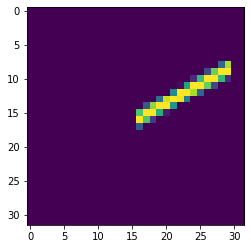

In [10]:
#save 5000 lines image
import imageio
import skimage.io as io
for i in range(n_dataset):
  im = dataset_train[i]
  im = np.array(im)
  imageio.imwrite(np.str(i)+'.jpg',im) #save
  #io.imsave(content/sample_data/lines32+np.str(i)+'.jpg',im)

im = dataset_train[1]
print(im.shape)
im = np.array(im)
#print(im)

#creat grey scale image
#imageio.imwrite('im.jpg', im)


from matplotlib import pyplot as plt
plt.imshow(im, interpolation='nearest')
plt.show()

In [11]:
import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn, optim
import torch.nn.functional as F

#from python_utils.import_ import import_global
#import_global('show_array') 
#from python_utils import show_array
#from python_utils import mosaic
#from show_array import *
#from mosaic import *
import sklearn
print(sklearn.__version__)
!apt update -qq
!apt install -qq cmake ffmpeg
#!pip install dlib

![[ ! -e utils ]] && \
  git clone https://github.com/kylemcdonald/python-utils -b show_array utils

0.22.2.post1
60 packages can be upgraded. Run 'apt list --upgradable' to see them.
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 60 not upgraded.
Cloning into 'utils'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 250 (delta 0), reused 0 (delta 0), pack-reused 248
Receiving objects: 100% (250/250), 53.00 KiB | 623.00 KiB/s, done.
Resolving deltas: 100% (140/140), done.
Note: checking out 'a4fd6c2f5275ae6b836f7d01caf42cf46a0af782'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another c

In [12]:

import os
from google.colab import drive
#mount google drive
drive.mount('/content/drive')
path = "/content/lines32"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:

print(os.getcwd())

/content/lines32/lines32_data500


In [14]:
#define class Dataset
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import torch.utils.data as data
root ='/content/lines32/'#调用图像
def default_loader(path):
    return Image.open(path).convert('L')
 
class MyTrainData(torch.utils.data.Dataset):
  def __init__(self, txt, transform=None,target_transform=None, loader=default_loader):
    super(MyTrainData,self).__init__()
    fh = open(txt, 'r')
    imgs = []
    for line in fh:
      line = line.strip('\n')
      line = line.rstrip('\n')
      words = line.split()
      imgs.append((words[0]))
    self.imgs = imgs
    self.transform = transform
    self.target_transform = target_transform
    self.loader = loader

  def __getitem__(self, index):
    fn = self.imgs[index]
    img = self.loader(fn)
    if self.transform is not None:
      img = self.transform(img)
    return img

 
  def __len__(self):
    return len(self.imgs) #这个是必须返回的长度

In [16]:

#write txt file for dataset
import os
dir = '/content/lines32/lines32_data500' + '/'
files = os.listdir(dir)
files.sort()
train = open('/content/lines32/train.txt','a')
val = open('/content/lines32/val.txt', 'a')
i = 1
for file in files:
  if i<402:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name =  str(dir) +  file + '\n'
    train.write(name)
    i = i+1
    print(i)
  else:
    fileType = os.path.split(file)
    if fileType[1] == '.txt':
      continue
    name = str(dir) +file + '\n'
    val.write(name)
    i = i+1
    print(i)
val.close()
train.close()

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

num_of_trainData: 400
num_of_testData: 100


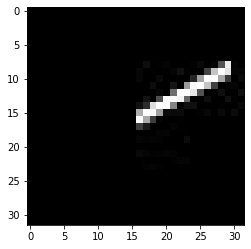

In [19]:
train_data=MyTrainData(txt=root+'train.txt', transform=transforms.ToTensor())
test_data = MyTrainData(txt=root+'val.txt', transform=transforms.ToTensor())
train_loader = DataLoader(dataset=train_data, batch_size = batch_size, shuffle=True,num_workers=2)
test_loader = DataLoader(dataset=test_data, batch_size = batch_size, shuffle=False,num_workers=2)
print('num_of_trainData:', len(train_data))
print('num_of_testData:', len(test_data))

import torchvision
img = torchvision.utils.make_grid(train_data[1]).numpy()
plt.imshow(np.transpose(img,(1,2,0)))
plt.show()

0 torch.Size([32, 1, 32, 32])


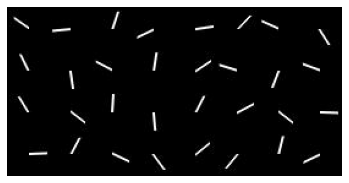

In [20]:
#show one batch
def show_batch(sample_batched):
  images_batch = sample_batched
  batch_size = len(images_batch)
  im_size = images_batch.size(2)
  grid = utils.make_grid(images_batch)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))

 
  
for i_batch, sample_batched in enumerate(train_loader):
  print(i_batch, sample_batched.size())
  if i_batch == 0:
    plt.figure()
    show_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    break


dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")


In [57]:
# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [21]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [41]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()            
            # state size. (ngf) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [42]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [43]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [44]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(32, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [60]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        #print(fake[1].shape)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 5 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 50 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/20][0/13]	Loss_D: 0.0024	Loss_G: 7.2525	D(x): 0.9990	D(G(z)): 0.0014 / 0.0011
[0/20][5/13]	Loss_D: 0.0028	Loss_G: 7.6305	D(x): 0.9982	D(G(z)): 0.0010 / 0.0006
[0/20][10/13]	Loss_D: 0.0029	Loss_G: 6.8947	D(x): 0.9988	D(G(z)): 0.0018 / 0.0013
[1/20][0/13]	Loss_D: 0.0300	Loss_G: 10.2321	D(x): 0.9987	D(G(z)): 0.0270 / 0.0113
[1/20][5/13]	Loss_D: 0.3308	Loss_G: 11.3697	D(x): 0.9026	D(G(z)): 0.0015 / 0.0009
[1/20][10/13]	Loss_D: 0.0083	Loss_G: 5.9035	D(x): 0.9980	D(G(z)): 0.0063 / 0.0059
[2/20][0/13]	Loss_D: 0.0176	Loss_G: 5.3653	D(x): 0.9972	D(G(z)): 0.0145 / 0.0089
[2/20][5/13]	Loss_D: 0.0084	Loss_G: 6.1413	D(x): 0.9979	D(G(z)): 0.0063 / 0.0041
[2/20][10/13]	Loss_D: 0.0080	Loss_G: 6.1737	D(x): 0.9964	D(G(z)): 0.0043 / 0.0032
[3/20][0/13]	Loss_D: 0.0070	Loss_G: 6.2536	D(x): 0.9979	D(G(z)): 0.0048 / 0.0030
[3/20][5/13]	Loss_D: 0.0065	Loss_G: 6.3382	D(x): 0.9971	D(G(z)): 0.0036 / 0.0022
[3/20][10/13]	Loss_D: 0.0090	Loss_G: 5.8408	D(x): 0.9957	D(G(z)): 0.0047 / 0.0

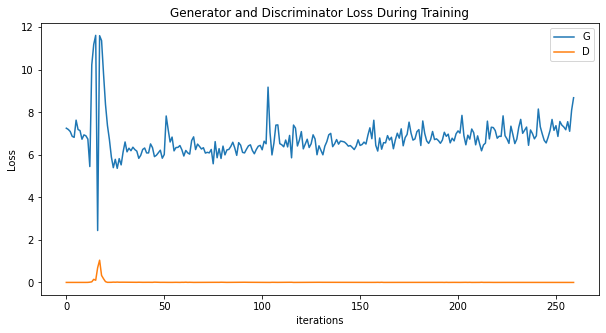

In [61]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

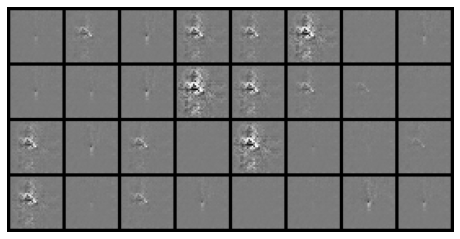

In [51]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

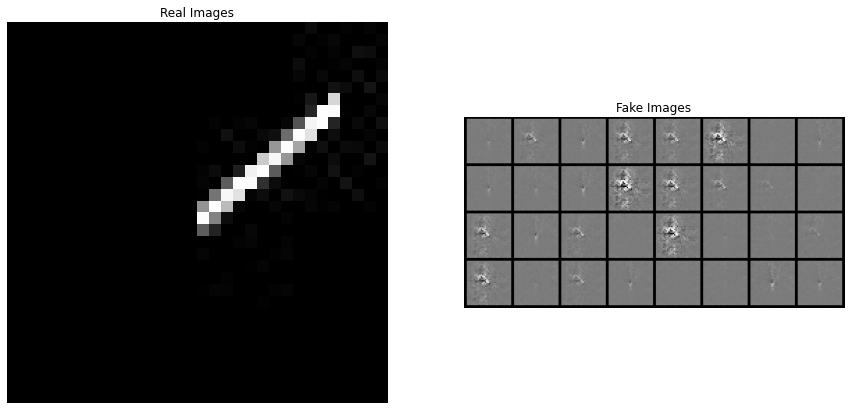

In [52]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()